In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classicalfield import FiniteTempGPE as gpe

from scipy.fft import fft2, ifft2, fftshift, ifftshift 
from scipy.optimize import curve_fit

In [17]:
impPsi = np.loadtxt('vortexsnaps_dt025.csv', dtype = np.complex_)

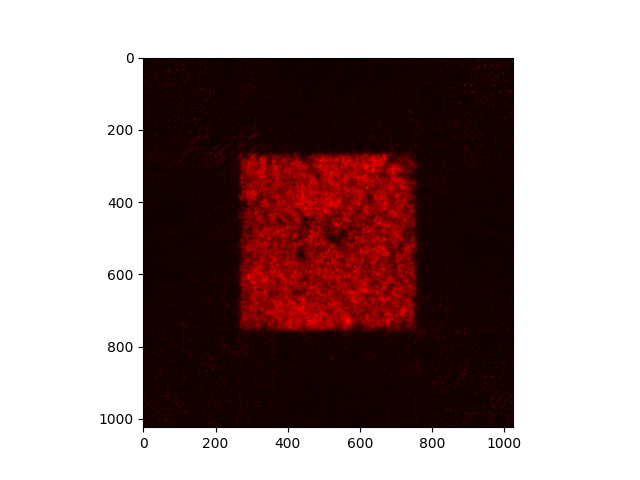

In [98]:
plt.figure() 
plt.imshow(np.abs(impPsi)**2, cmap = plt.cm.hot)
plt.show() 

In [18]:
g = gpe(numImagSteps=500, numRealSteps = 200000, winMult = 3, dtcoef = 0.025, Nsamples=1, vortex = True, Tfact =1/50, imp = False) # 15, 10000
# figure out if the animation works for T = 0 still 

Total Imag Time:  53.97546863555908


In [16]:
g.simulate(100000)
# compare the result of this to a simulation directly from vortexclean.py 

In [56]:
1000*g.gpeobj.dt


0.95367431640625

Test the average over the medium simulation time - make the plots look nice and see if the averages make sense 

Simulate for longer over few samples - does the vortex movement still make sense? 



In [23]:
# coef=g.winL/g.dx**2
# ksamples = np.zeros((g.Nsamples, len(g.ki[0][0]), len(g.ki[0][0])), dtype = np.complex_)
# psix_arr = np.zeros((g.Nsamples, len(g.ki[0][0]), len(g.ki[0][0])), dtype = np.complex_)
# thermal_wf_samples = np.zeros((g.Nsamples, len(g.ki[0][0]), len(g.ki[0][0])), dtype = np.complex_)
# for i in range(g.Nsamples): 
#     ksamples[i] = g.genPsiK()
#     psik_sp = coef * (ksamples[i])
#     psix_arr[i] = ifft2(psik_sp) 
#     thermal_sample = g.gs + psix_arr[i] 
#     thermal_sample[g.gpeobj.psi_init<0.1] = 0
#     norm = np.sum(np.abs(thermal_sample)**2 * g.dx**2)

#     thermal_wf_samples[i] = np.sqrt(g.gpeobj.Natoms/norm)*thermal_sample

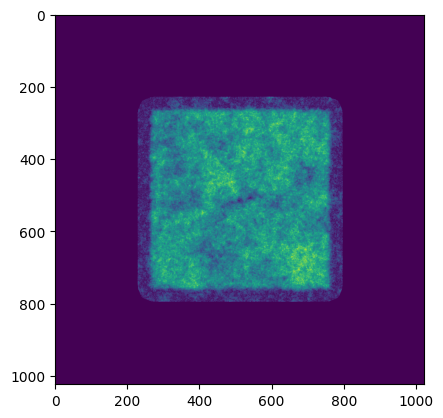

In [24]:
# temp = g.gs + psix_arr[i]
# temp2 = g.gs + psix_arr[i]
# temp[np.abs(g.gs)<0.001] = 0
# plt.imshow(np.abs(temp))

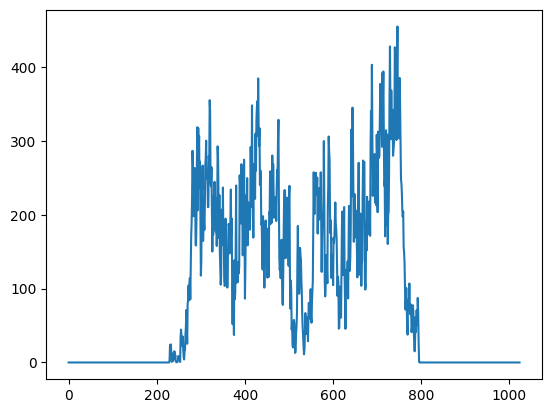

In [25]:
# plt.plot(np.abs(temp[len(temp)//2])**2)
# #plt.plot(np.abs(temp2[len(temp2)//2])**2)

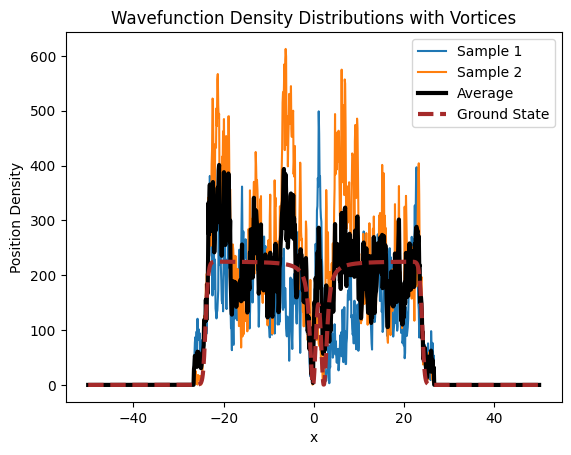

In [64]:
avg_dens = np.mean(np.abs(g.final_psis)**2, axis = 0, dtype = np.complex_)

plt.figure() 
for i in range(len(g.final_psis)): 
    plt.plot(g.xi[0][0], np.abs(g.final_psis[i])[len(g.final_psis[0])//2]**2, label = f'Sample {i+1}')
plt.plot(g.xi[0][0], np.abs(avg_dens)[len(avg_dens)//2], label = 'Average', color = 'black', linewidth = 3)
plt.plot(g.xi[0][0], np.abs(g.gs)[len(g.gs)//2]**2, linestyle = '--', color = 'brown', linewidth = 3, label = 'Ground State')
plt.xlabel('x')
plt.title('Wavefunction Density Distributions with Vortices')
plt.ylabel('Position Density')
plt.legend() 

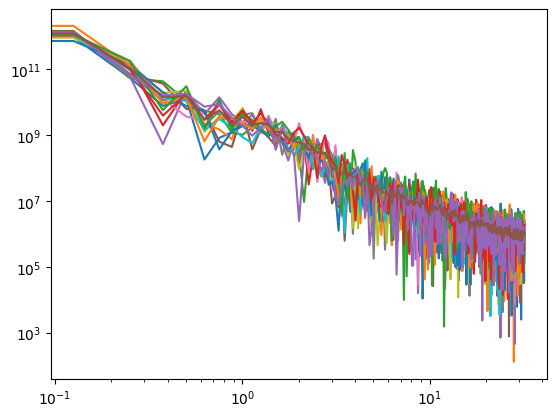

In [41]:
# now test in k space 

kdens_avg = np.mean(np.abs(g.short_wfk)**2, axis = 0, dtype = np.complex_)

plt.figure() 
for i in range(len(g.final_psis)): 
    plt.plot(fftshift(g.kgrid_short), fftshift(np.abs(g.short_wfk[i])[0]**2))
# for i in range(len(g.short_wfk)):
#     plt.plot(fftshift(g.kgrid_short), fftshift(np.abs(g.short_wfk[i])[0]**2))
plt.plot(fftshift(g.kgrid_short), fftshift(kdens_avg[0]))
plt.yscale('log')
plt.xscale('log')

In [42]:
def fittingfunc(x, b, m): 
    return b* x**m

def cleandata(grid, noise): 
    mask = (grid > 0) & (noise > 0)

    grid_clean = grid[mask]
    noise_clean = noise[mask]

    return grid_clean, noise_clean

In [43]:
thres = 30
k_clean, noise_clean = cleandata(g.kgrid_short, kdens_avg[0])
popt, pcov = curve_fit(fittingfunc, k_clean[thres:], noise_clean[thres:])
print(popt)

[ 1.07297147e+09 -2.23619764e+00]


C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


In [44]:
coef = g.winL/g.dx**2/2
k_samples = [] 

for i in range(25): 
     k_samples.append(coef * g.genPsiK())
k_samples = np.array(k_samples) 
avg_k_samples = np.mean(np.abs(k_samples)**2, axis = 0, dtype = np.complex_)

psik = g.winL/g.dx**2*g.genPsiK() 

(511,)


C:\Users\TQC User\AppData\Local\Temp\ipykernel_6148\1170982049.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(g.ki[0][0], coef**2*2*g.T/g.ki[0][0]**2, label = 'Theory')


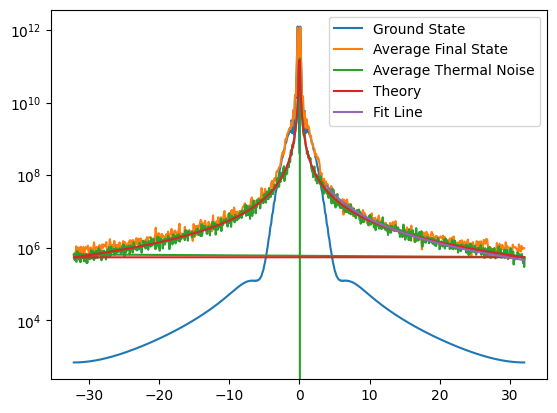

In [45]:
## Check to see where the thermal noise dominates the wavefunction 
params = g.extractBox(g.xi, g.gs) 
gs_k = fft2(g.gs) 
print(np.shape(params[2]))
plt.plot(fftshift(params[2]), fftshift(np.abs(params[3][0])**2), label = 'Ground State')
plt.plot(fftshift(g.kgrid_short), fftshift(kdens_avg[0]), label = 'Average Final State')

plt.plot(g.ki[0][0], avg_k_samples[0], label = 'Average Thermal Noise')
plt.plot(g.ki[0][0], coef**2*2*g.T/g.ki[0][0]**2, label = 'Theory')

plt.plot(k_clean[thres:], fittingfunc(k_clean[thres:], *popt), label = 'Fit Line')
plt.yscale('log')
plt.legend() 
#plt.xscale('log')

Text(0, 0.5, 'Position Density')

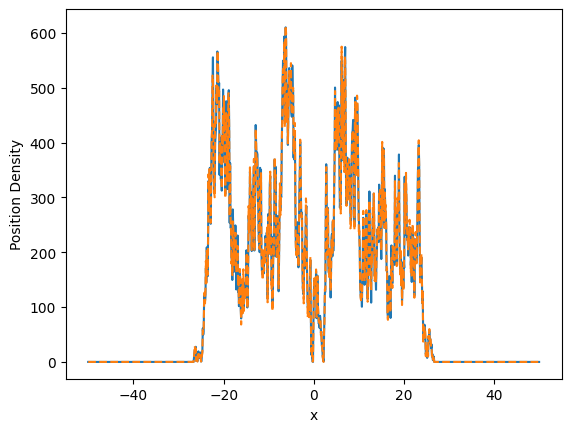

In [66]:
plt.plot(g.xi[0][0], np.abs(g.snaps[0][len(g.snaps[0])//2])**2)
plt.plot(g.xi[0][0], np.abs(g.snaps[-1][len(g.snaps[0])//2])**2, linestyle = '--')
plt.xlabel('x')
plt.ylabel('Position Density')
plt.title('Position Distibution with Vortices before and after Propagation')

C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


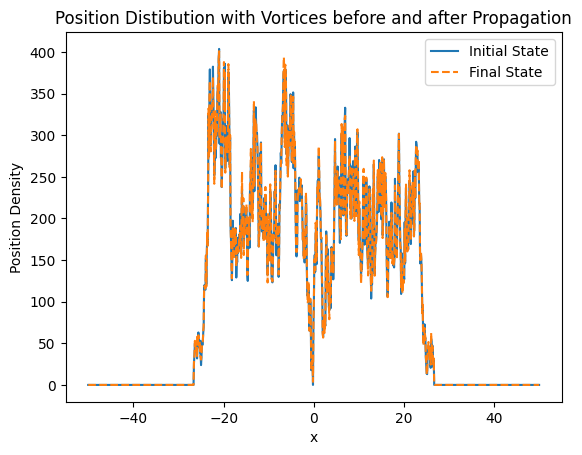

In [79]:
avg_initx = np.mean(np.abs(g.wf_samples)**2, axis = 0, dtype = np.complex_)
avg_finalx = np.mean(np.abs(g.final_psis)**2, axis = 0, dtype = np.complex_)

plt.plot(g.xi[0][0], avg_initx[len(g.snaps[0])//2], label = 'Initial State')
plt.plot(g.xi[0][0], avg_finalx[len(g.snaps[0])//2], linestyle = '--', label = 'Final State')
plt.xlabel('x')
plt.ylabel('Position Density')
plt.title('Position Distibution with Vortices before and after Propagation')
plt.legend() 

C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


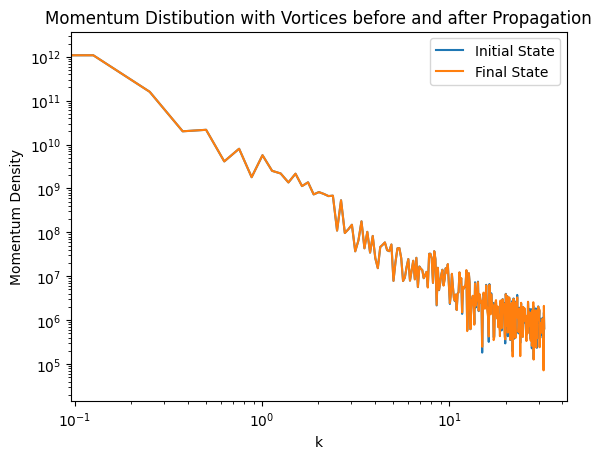

In [82]:
init_k_states = [] 

grid = g.extractBox(g.xi, g.wf_samples[0])[2]
for i in range(len(g.wf_samples)): 
    init_k_states.append(g.extractBox(g.xi, g.wf_samples[i])[3])

avg_initk = np.mean(np.abs(init_k_states)**2, axis = 0, dtype = np.complex_)
avg_finalk = np.mean(np.abs(g.short_wfk)**2, axis = 0, dtype = np.complex_)

plt.plot(fftshift(grid), fftshift(avg_initk[0]), label = 'Initial State')
plt.plot(fftshift(grid), fftshift(avg_finalk[0]), label = 'Final State')
plt.yscale('log') 
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Momentum Density')
plt.title('Momentum Distibution with Vortices before and after Propagation')
plt.legend() 

In [3]:
import matplotlib.animation as animation

In [24]:
def animatepsi2d(filename):
    if filename != None: 
        path = fr"C:\Users\TQC User\Desktop\BECs\{filename}.mp4"

    fig, ax = plt.subplots() 
    data = plt.imshow(np.abs(g.snaps[0])**2, extent = [-g.winL/2, g.winL/2, -g.winL/2, g.winL/2],cmap = plt.cm.hot)
    
    time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='red', alpha=0.5))
    time_text.set_text('time = 0')

    plt.xlabel("x", fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    # plt.contour(self.xi[0], self.xi[1], self.Vs)
    plt.title(f'Animation for L={g.L}')

    def animate(i): 
        data.set_data(np.abs(g.snaps[i])**2)

        time_text.set_text('time = %.1d' % g.time_tracking[i])
        return data, time_text
    anim = animation.FuncAnimation(fig, animate, frames = len(g.snaps), blit = True)

    plt.show() 
    
    anim.save(path)

    return anim

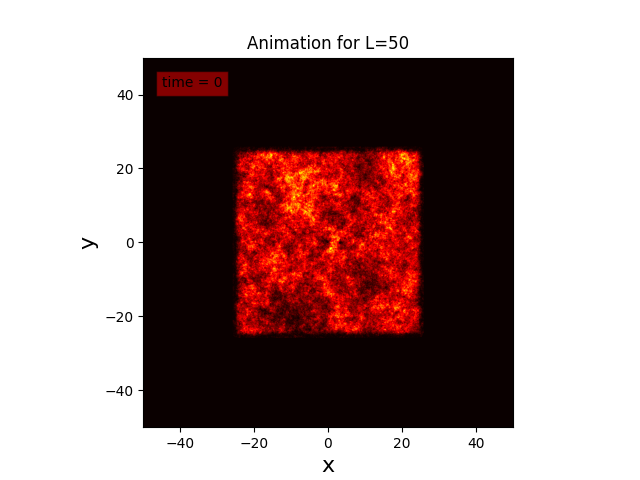

In [25]:
%matplotlib widget
animatepsi2d('test8_2_dens')

In [20]:
print(g.gpeobj.dt*170000)
print(g.gpeobj.dt)

40.531158447265625
0.0002384185791015625


In [8]:
print(len(g.snaps))

801


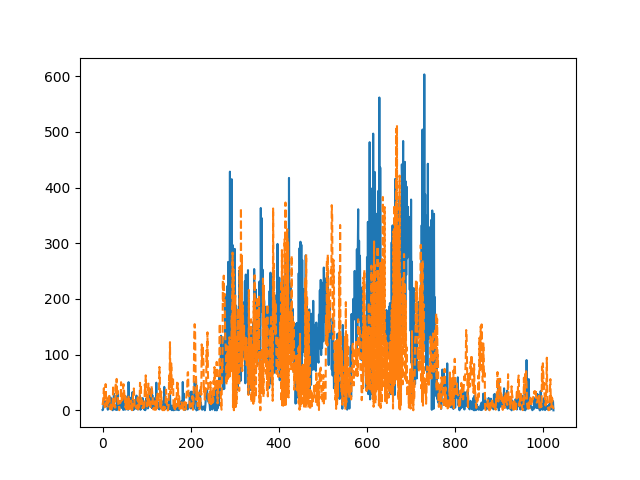

In [21]:
plt.figure() 
plt.plot(np.abs(g.snaps[1][len(g.snaps[0])//2])**2)
plt.plot(np.abs(g.snaps[-1][len(g.snaps[0])//2])**2, linestyle = '--')
plt.show()

C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


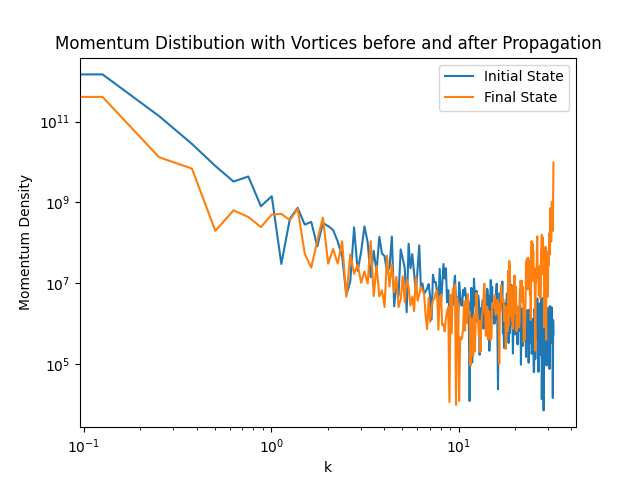

In [22]:
init_k_states = [] 

grid = g.extractBox(g.xi, g.wf_samples[0])[2]
for i in range(len(g.wf_samples)): 
    init_k_states.append(g.extractBox(g.xi, g.wf_samples[i])[3])

# mid_k_states = (g.extractBox(g.xi, g.snaps[2])[3])
# mid_k_states2 = (g.extractBox(g.xi, g.snaps[20])[3])

avg_initk = np.mean(np.abs(init_k_states)**2, axis = 0, dtype = np.complex_)
avg_finalk = np.mean(np.abs(g.short_wfk)**2, axis = 0, dtype = np.complex_)

plt.figure() 
plt.plot(fftshift(grid), fftshift(avg_initk[0]), label = 'Initial State')
# plt.plot(fftshift(grid), fftshift(np.abs(mid_k_states[0])**2), label = 'Intermediate State')
# plt.plot(fftshift(grid), fftshift(np.abs(mid_k_states2[0])**2), label = 'Intermediate State')
plt.plot(fftshift(grid), fftshift(avg_finalk[0]), label = 'Final State')
plt.yscale('log') 
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Momentum Density')
plt.title('Momentum Distibution with Vortices before and after Propagation')
plt.legend() 
plt.show() 

In [16]:
np.savetxt('vortexsnaps_dt025.csv', g.snaps[-1])

In [56]:
print(len(g.snaps))

33


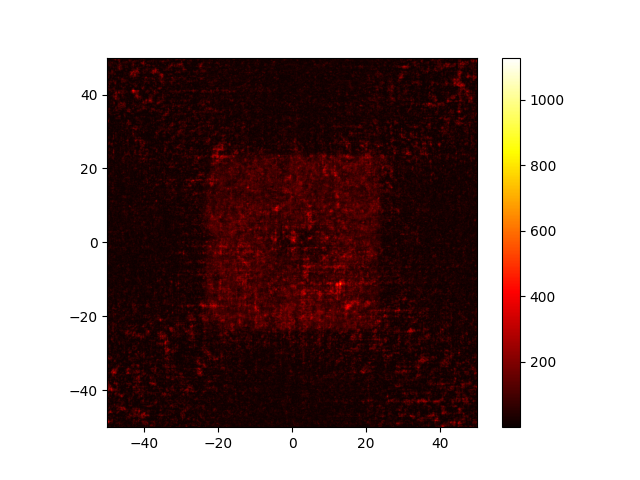

In [23]:
plt.figure() 
plt.imshow(np.abs(g.snaps[-1])**2, extent = [-g.winL/2, g.winL/2, -g.winL/2, g.winL/2],cmap = plt.cm.hot)
plt.colorbar() 
plt.show() 